In [1]:
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('eda_polarity.csv',index_col = False)
df=df.dropna()
df.head()

,Data,Polarity
0,balenciaga and the rise of trash by umair haque,0
1,removed the balenciaga scandal broke,0
2,omega aqua terra i really wanted an explorer p...,0
3,they seem to have a life of their own crazy di...,0
4,since i dont twitter and shoe only put up a mi...,0


## Stacked Ensemble

In [3]:
# Split the Dataset into random Train and Test
X_train, X_test, y_train, y_test = train_test_split(df['Data'], df['Polarity'], test_size = 0.30, random_state = 42)

# Check the sample sizes
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

Train Set : (10764,) (10764,)
Test Set  : (4614,) (4614,)


In [4]:
# Split the Dataset into random Train and Test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.50, random_state = 42)

# Check the sample sizes
print("Train Set :", X_train.shape, y_train.shape)
print("Val Set  :", X_val.shape, y_val.shape)
X_train

Train Set : (5382,) (5382,)
Val Set  : (5382,) (5382,)


14569         naan tell me how to love kianna dior tribute
9223     nan wts conus rolex milgauss gv gmf factory tr...
12206    there has new changes in the studio of balenci...
14319    my theory is that the lostbelt kingqueen of na...
6736     xb xb user playerome display is mellifluous xb...
                               ...                        
13006                 horhead sales nice work tiffanyandco
12425    dior savauge has become the warm vanilla extra...
6034     check out this listing i just to my poshmark c...
4663     hi everyone i saw a lady dior in python skin a...
13729    nan louis vuitton x yk christopher backpack th...
Name: Data, Length: 5382, dtype: object

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range = (1, 3), binary = True, smooth_idf = False)

X_train = tf_idf.fit_transform(X_train)
X_val=tf_idf.transform(X_val)
X_test = tf_idf.transform(X_test)

In [6]:
#importing the packages

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

Best alpha:  1.0


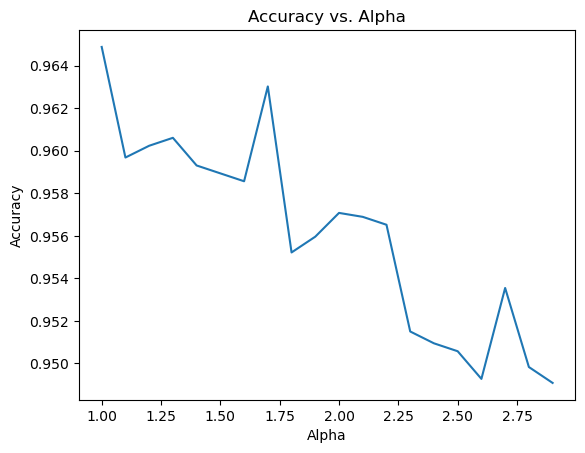

In [7]:
def get_accuracy_CV(model):

    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle = True)

    # Get Accuracy scores
    accuracy = cross_val_score(model, X_train, y_train, scoring = "accuracy", cv = kf)

    return accuracy.mean()

res = pd.Series([get_accuracy_CV(MultinomialNB(alpha = i)) for i in np.arange(1, 3, 0.1)], index = np.arange(1, 3, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('Accuracy vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()

In [8]:
#specifying the initial learners
model1 = MultinomialNB(alpha = 1.0)
#model2 = LogisticRegression(random_state=42,max_iter=1000)
model3 = SVC(kernel = 'rbf', random_state = 42)

In [9]:
#training the initial learners
model1.fit(X_train,y_train)
#model2.fit(X_train,y_train)
model3.fit(X_train,y_train)

SVC(random_state=42)

In [10]:
#making predictions for the validation data
preds1 = model1.predict(X_val)
#preds2 = model2.predict(X_val)
preds3 = model3.predict(X_val)

#making predictions for the test data
test_preds1 = model1.predict(X_test)
#test_preds2 = model2.predict(X_test)
test_preds3 = model3.predict(X_test)


In [11]:
#making a new dataset for training our final model by stacking the predictions on the validation data
train_stack = np.column_stack((preds1,preds3))

#making the final test set for our final model by stacking the predictions on the test data
test_stack = np.column_stack((test_preds1,test_preds3))

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
final_model = RandomForestClassifier()

#training the final model on the stacked predictions
final_model.fit(train_stack,y_val)

RandomForestClassifier()

Accuracy: 98.29%
f1: 0.98
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1548
           2       0.99      0.98      0.98      1559
           4       0.98      0.98      0.98      1507

    accuracy                           0.98      4614
   macro avg       0.98      0.98      0.98      4614
weighted avg       0.98      0.98      0.98      4614



<AxesSubplot: >

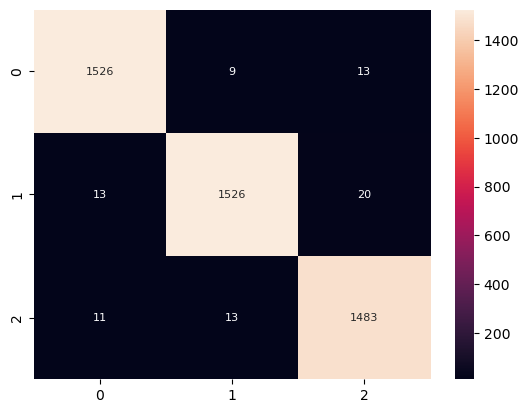

In [14]:
final_predictions = final_model.predict(test_stack)

accuracy = accuracy_score(y_test, final_predictions)
print(f'Accuracy: {accuracy*100:.2f}%')

f1 = f1_score(y_test, final_predictions,average='weighted')
print(f'f1: {f1*1:.2f}')

# Print Classification Report
print(classification_report(y_test, final_predictions))

# Plot the Confusion Matrix for Test 
sns.heatmap(confusion_matrix(y_test, final_predictions), 
           annot = True, fmt=".0f", annot_kws={"size": 8})

In [19]:
preds=['I hate this watch', 'I love this thing']

predict_neg = tf_idf.transform(preds)

p1 = model1.predict(predict_neg)
p3 = model3.predict(predict_neg)


stack = np.column_stack((p1,p3))

ValueError: X has 181059 features, but RandomForestClassifier is expecting 2 features as input.